# ABS Quarterly Business Indicators 5676

## Python set-up

In [1]:
# standard library imports
import sys

# analytic imports
import pandas as pd
import matplotlib.pyplot as plt

# local imports
from henderson import hma
from abs_data_capture import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
    fix_abs_title,
    get_meta_constants,
    find_id,
)
from plotting import (
    finalise_plot,
    set_chart_dir,
    recalibrate_series,
    clear_chart_dir,
    plot_growth_finalise,
    calc_growth,
)

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# plotting stuff
plt.style.use("fivethirtyeight")

In [2]:
catalogue_id = "5676"
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction
abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

meta = abs_dict[META_DATA]
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()
RECENT, plot_times, plot_tags = get_plot_constants(meta)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

### Headline charts

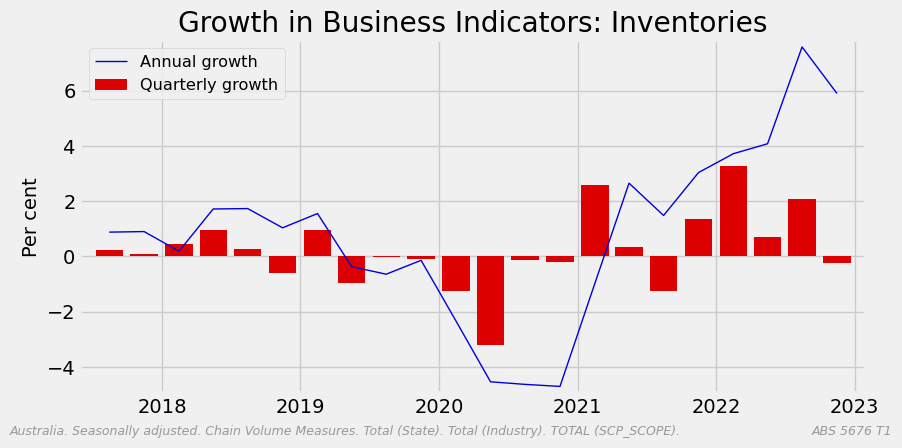

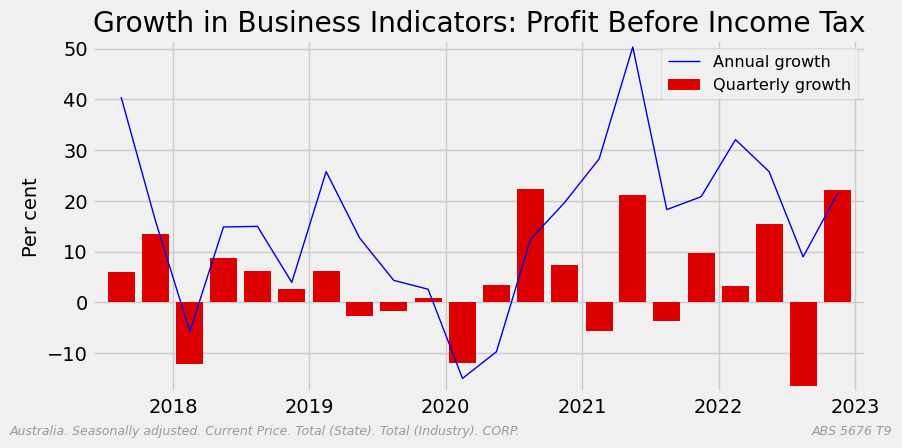

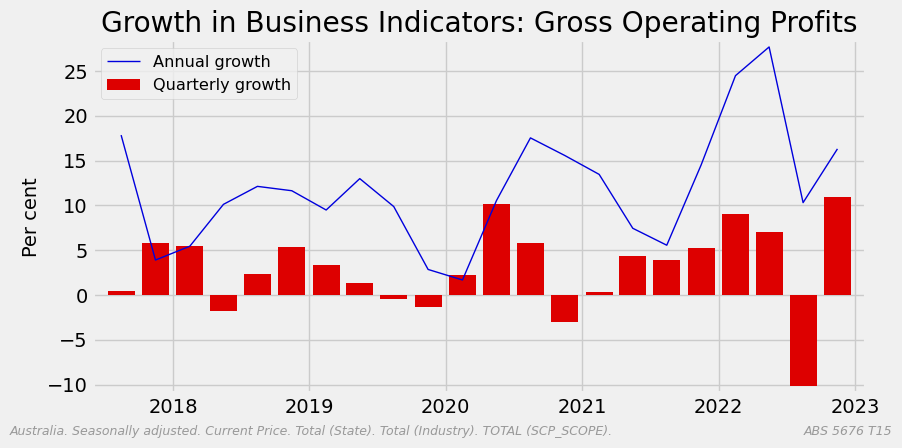

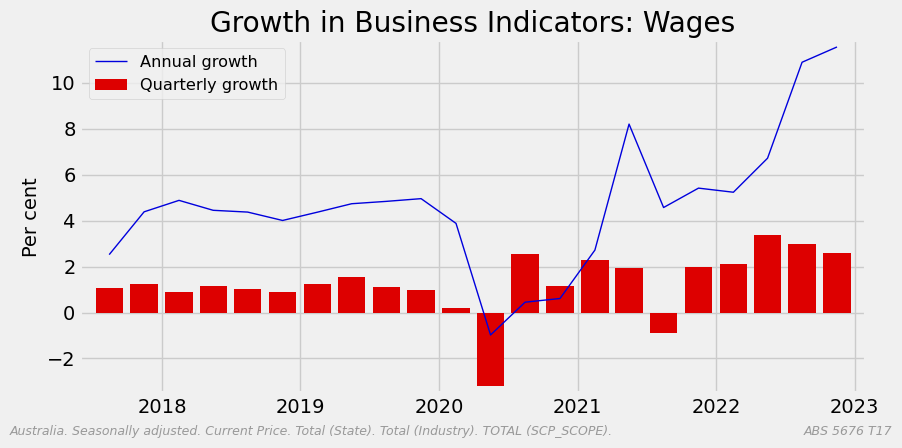

In [5]:
series_type = "Seasonally Adjusted"
headlines = [
    "Inventories ;  Total (State) ;  Total (Industry) ;  Chain Volume Measures ;",
    "Profit before Income Tax ;  Total (State) ;  Total (Industry) ;  Current Price ;  CORP ;",
    "Gross Operating Profits ;  Total (State) ;  Total (Industry) ;  Current Price ;  TOTAL (SCP_SCOPE) ;",
    "Wages ;  Total (State) ;  Total (Industry) ;  Current Price ;",
]
recent = plot_times[1]
for h in headlines:
    # get the data
    row = meta[
        (meta[type_col] == series_type) & meta[did_col].str.contains(h, regex=False)
    ].iloc[0]
    series_id, units, table = row[id_col], row[unit_col], row[table_col]
    series, units = recalibrate_series(abs_dict[table][series_id], units)

    # plot
    lfooter = f"Australia. {series_type.capitalize()}. "
    title, lfooter = fix_abs_title(f"Business indicators: {row[did_col]}", lfooter)
    ax = series[series.index > pd.Period(recent, freq="Q")].plot()
    finalise_plot(
        ax,
        title=title,
        ylabel=units,
        pre_tag="!",
        rfooter=f"{source} T{table}",
        lfooter=lfooter,
        # show=True,
    )

    growth = calc_growth(series)
    plot_growth_finalise(
        *growth,
        from_=pd.Period(recent, freq="Q"),
        title=f"Growth in {title.title()}",
        pre_tag="!",
        rfooter=f"{source} T{table}",
        lfooter=lfooter,
        show=True,
    )

### Profits vs wages

In [6]:
series_type = "Seasonally Adjusted"

wages_table = '17'
wages_did = 'Wages ;  Total (State) ;  Total (Industry) ;  Current Price ;'
wages_name = wages_did.split(';')[0].strip()
wages_id, wage_units = find_id(
    meta, 
    {
        wages_table: table_col, 
        series_type: type_col,
        wages_did: did_col,
    },
    verbose=False
)
wages = abs_dict[wages_table][wages_id].dropna()
print(wages.index[0])

profits_table = '15'
profits_did = 'Gross Operating Profits ;  Total (State) ;  Total (Industry) ;  Current Price ;  TOTAL (SCP_SCOPE) ;'
profits_name = profits_did.split(';')[0].strip()
profits_id, profits_units = find_id(
    meta, 
    {
        profits_table: table_col, 
        series_type: type_col,
        profits_did: did_col,
    },
    verbose=False
)
profits = abs_dict[profits_table][profits_id].dropna()
print(profits.index[0])

# plot profits as a share of wages and prices
assert wage_units == profits_units
rfooter = f"{source} Tables: {wages_table}:{wages_id}, {profits_table}:{profits_id}"
profit_wage_share = profits / (profits + wages) * 100
ax = profit_wage_share.plot(lw=1, color='darkblue', label=f'{profits_name} share')
hma_term = 7
hma(profit_wage_share.dropna(), hma_term).plot(lw=3, color='darkorange', ax=ax, label='Henderson moving average')
ax.legend(loc='best', fontsize='x-small')
finalise_plot(
    ax,
    title='Profits as a share of profits plus wages',
    ylabel='Per cent',
    rfooter=rfooter,
    lfooter=f'Australia. {series_type.capitalize()} series. '
            f'{hma_term}-term Henderson moving average. ',
    # show=True,
)

# Plot values
assert 'Current Price' in wages_did and 'Current Price' in profits_did
assert 'Millions' in wage_units
ax = (wages / 1000).plot(lw=2, color='darkblue', label=f'{wages_name}')
(profits / 1000).plot(lw=2, color='darkorange', label=f'{profits_name}', ax=ax)
ax.legend(loc='best', fontsize='x-small')
finalise_plot(
    ax,
    title='Profits vs Wages',
    ylabel='$ Billions',
    rfooter=rfooter,
    lfooter=f'Australia. {series_type.capitalize()} series. Current Prices. ',
    # show=True,
)

# plot wage and profits index (note starting point ptoblem)
assert profits.index[0] == wages.index[0]  # common start
profits_index = profits / profits.iloc[0] * 100
wages_index = wages / wages.iloc[0] * 100
ax = wages_index.plot(lw=2, color='darkblue', label=f'{wages_name} index')
profits_index.plot(lw=2, color='darkorange', label=f'{profits_name} index', ax=ax)
ax.legend(loc='best', fontsize='x-small')
finalise_plot(
    ax,
    title='Profits index vs Wages index',
    ylabel='Index',
    rfooter=rfooter,
    lfooter=f'Australia. {series_type.capitalize()} series. Current Prices. ',
    # show=True,
)


2001Q1
2001Q1


### Inventories by industry sector

In [7]:
# identify the plotable items ...
series_type = "Seasonally Adjusted"
measure_type = "Chain Volume Measures"
rows = meta[
    (meta[type_col] == series_type)
    & meta[did_col].str.contains("Inventories", regex=False)
    & meta[did_col].str.contains(measure_type, regex=False)
    & meta[unit_col].str.contains("$", regex=False)
]

for index, row in rows.iterrows():
    # get the data for wacg poltable item
    series_id, units, table = row[id_col], row[unit_col], row[table_col]
    data = abs_dict[table]
    series, units = recalibrate_series(data[series_id], units)

    # plot the data
    lfooter = f"Australia. {series_type.capitalize()}. "
    title, lfooter = fix_abs_title(row[did_col], lfooter)
    ax = series[series.index >= pd.Period(recent, freq="Q")].plot()
    finalise_plot(
        ax,
        title=title,
        ylabel=units,
        tag="inventories",
        rfooter=f"{source} T{table}",
        lfooter=lfooter,
        # show=True
    )

## Wages Growth

In [8]:
series_type = "Seasonally Adjusted"
series_did = "Wages"
rows = meta[
    meta[did_col].str.contains(series_did, regex=False)
    & (meta[type_col] == series_type)
    & meta[unit_col].str.contains("$", regex=False)
]

for index, row in rows.iterrows():
    # get the data
    series_id, units, table = row[id_col], row[unit_col], row[table_col]
    data = abs_dict[table]
    series, units = recalibrate_series(data[series_id], units)
    lfooter = f"Australia. {series_type.capitalize()}. "
    title, lfooter = fix_abs_title(row[did_col], lfooter)
    growth = calc_growth(series)
    plot_growth_finalise(
        *growth,
        from_=pd.Period(recent, freq="Q"),
        title=f"Growth: {title}",
        rfooter=f"{source} T{table}",
        lfooter=lfooter,
        # show=True,
    )

## Finished

In [9]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Mar 03 2023 12:57:08

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

pandas    : 1.5.3
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
matplotlib: 3.7.0

Watermark: 2.3.1



In [10]:
print("Finished")

Finished
